# Classificação de dígitos usando CNNS

Realizaremos agora a mesma classificação feita com camadas lineares, mas utilizaremos uma CNN

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from dataset import load_mnist
import train

ds_train, ds_valid = load_mnist()

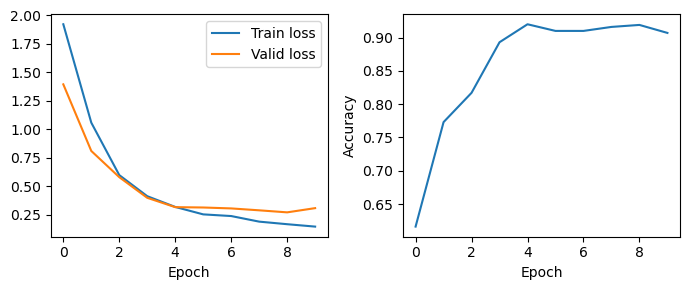

CPU times: user 27.1 s, sys: 1.27 s, total: 28.4 s
Wall time: 34.7 s


In [2]:
%%time
class Model(nn.Module):
    '''Modelo com uma camada convolucional'''
    def __init__(self):
        super().__init__()

        # 10 canais de convolução
        self.conv = nn.Conv2d(1, 10, kernel_size=13, padding=13//2)
        # Pooling fixando a saída em uma imagem de tamanho 2x2
        self.pool = nn.AdaptiveMaxPool2d(2)
        # Camada linear que recebe 10 imagens de tamanho 2x2 e gera 10 valores de saída
        self.fc = nn.Linear(10*2*2, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        # Transformação das imagens de tamanho bs x 10 x 2 x 2 para bs x 10*2*2
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
model = Model()
logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=10, lr=0.01)

### Salvando e carregando a rede treinada

In [3]:
checkpoint = {
    'params':{
        'bs':8,
        'num_epochs':10,
        'lr':0.01
    },
    'model':model.state_dict()
}
torch.save(checkpoint, '../data/checkpoints/M04/mnist_model.pt')

Após salvar a rede, podemos sempre ler novamente ela do disco:

In [4]:
checkpoint = torch.load('../data/checkpoints/M04/mnist_model.pt')
model = Model()
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Interpretação dos filtros gerados pela rede

A camada de convolução possui 10 filtros. Cada filtro possui tamanho 13x13. Podemos tentar entender o significado desses filtros

#### Visualização dos filtros

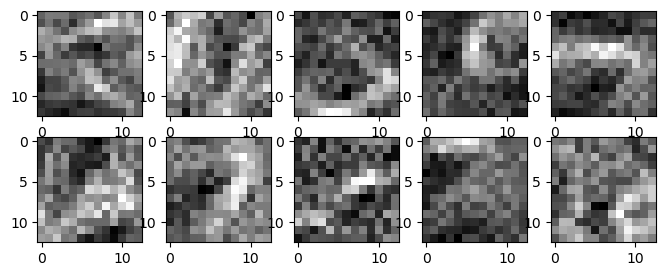

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(8,3))
axs = axs.reshape(-1)
for idx in range(10):
    axs[idx].imshow(model.conv.weight[idx,0].detach(), 'gray')

#### Visualização da convolução entre imagens e cada filtro

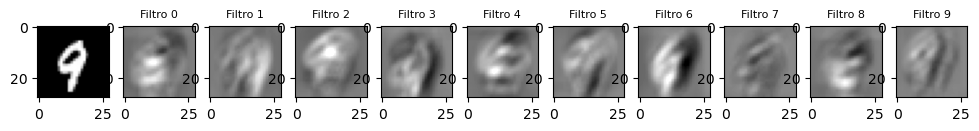

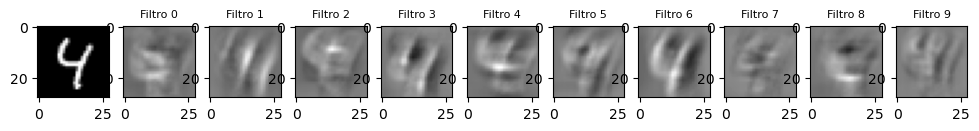

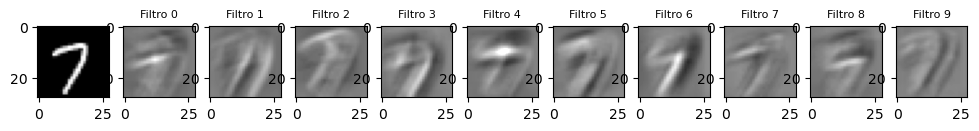

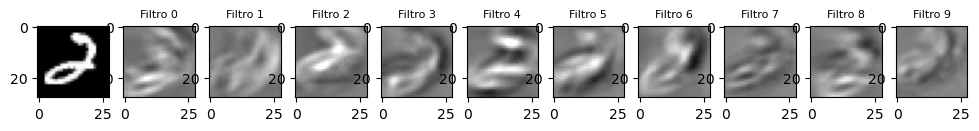

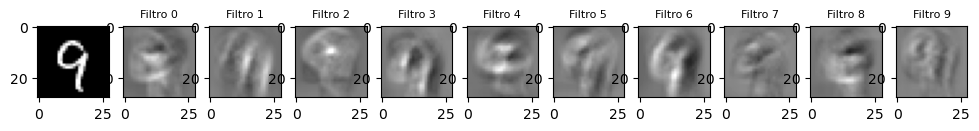

In [6]:
for idx in range(5):
    img, target = ds_train[idx]
    # Inclusão da dimensão de batch (batch contendo uma imagem)
    batch = img.unsqueeze(0)
    # Aplica apenas a camada de convolução em uma imagem:
    with torch.no_grad():
        res = model.conv(batch)

    fig, axs = plt.subplots(1,11, figsize=(12,3))
    axs = axs.reshape(-1)
    axs[0].imshow(img[0], 'gray')
    for channel in range(10):
        axs[channel+1].imshow(res[0,channel], 'gray', vmin=-10, vmax=10)
        axs[channel+1].set_title(f'Filtro {channel}', size=8)